# Numerical investigations, error measurements, and convergence tests

Finally, we want to put pieces together. As an orientation we can start with the simple Poisson demos provided in `demos` and make sure the 1D and 2D demos run through successfully.

### Task `Solve`-1:

Now, we want to measure errors. To this end write a function `error(u_h, u_exact)` that computes the $L^2$-error between the approximate solution `u_h` and the exact solution `u_exact` in the $L^2$ norm, i.e.
$$
    \int_{\Omega} (u_h - u_{\text{exact}})^2 \, dx.
$$
The function should return the error as a scalar. To this end use a loop over elements similar to the one in the `assemble`-functions. On each element use proper integration rules and proceed similar to the procedure in `compute_element_....` functions.

To find a setting where you can verify your implementation, use the following "trick", sometimes known as the method of "manufactured solution":
* Choose a (nice) function $u_{\text{exact}}$ (with proper boundary conditions, i.e. $\partial_n u_{\text{exact}}=0$ on $\partial \Omega$).
* Compute the right hand side $f$ by plugging $u_{\text{exact}}$ into the PDE.
* Solve the PDE numerically with the right hand side $f$ which yields an approximate solution $u_h$.

In [3]:
import import_hack
from methodsnm.fes import *
from methodsnm.forms import *
from methodsnm.formint import *
from methodsnm.mesh_1d import *
from methodsnm.visualize import *
import math
from tqdm import tqdm
from scipy.sparse.linalg import spsolve

def errortest(n):
    mesh = Mesh1D((0,1),n)
    fes = P1_Segments_Space(mesh)

    ue=GlobalFunction(lambda x: math.cos(x*math.pi), mesh = mesh)



    lf = LinearForm(fes)
    uef = GlobalFunction(lambda x:math.cos(x*math.pi)+math.cos(x*math.pi)*math.pi**2,mesh = mesh)
    lf += SourceIntegral(uef)
    lf.assemble()
    #print(lf.vector)

    blf = BilinearForm(fes)
    c = GlobalFunction(lambda x:1, mesh = mesh)
    blf += LaplaceIntegral(c)
    blf += MassIntegral(c)
    blf.assemble()
    #print(blf.matrix)
    #print(blf.matrix)
    uh = FEFunction(fes)
    uh.vector = spsolve(blf.matrix, lf.vector)
    #print(uh.vector)
    return error(uh,ue)
errortest(8)

0.018923572753811364

In [4]:
DrawFunction1D(uh)
DrawFunction1D(uef)

NameError: name 'uh' is not defined

### Task `Solve`-2:

Next, carry out a convergence study. Let $h$ be the minimal mesh size in your 1D/2D mesh. Observe for a fixed type of finite element space the convergence rate of the error in the $L^2$-norm. 

Carry out the experiment for different finite element spaces.

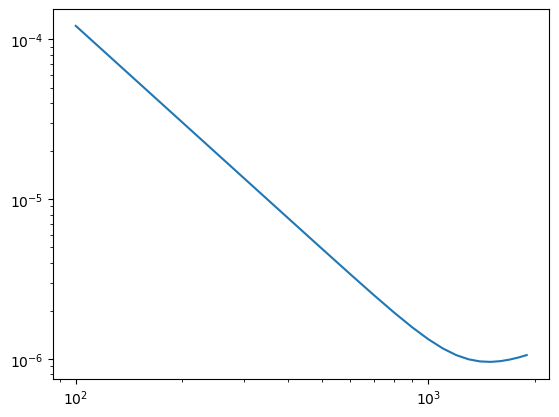

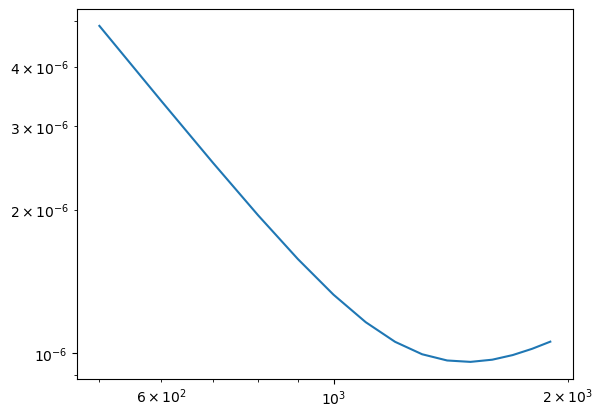

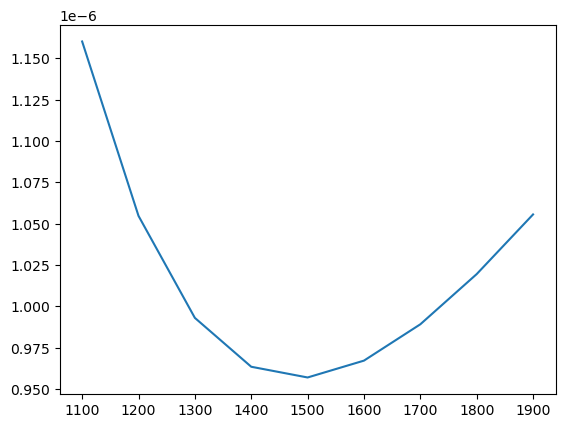

In [5]:
from matplotlib import pyplot as plt
res=[]
for n in range(100,2000,100):
    res.append([n,errortest(n)])
plt.loglog()
plt.plot(np.array(res)[:,0],np.array(res)[:,1])
plt.show()
plt.loglog()
plt.plot(np.array(res)[3:,0],np.array(res)[3:,1])
plt.show()
plt.loglog()
plt.plot(np.array(res)[4:,0],np.array(res)[4:,1])
plt.show()

plt.plot(np.array(res)[10:,0],np.array(res)[10:,1])

### Task `Solve`-3:

Now, implement the computation of the $H^1$ error:
$$
    \int_{\Omega} \|(\nabla (u_h - u_{\text{exact}}) \|^2+ (u_h - u_{\text{exact}})^2 \, dx
$$
and repeat the convergence studies. What do you observe?

### Task `Solve`-4:

Given a (2D or 1D) domain. We now want to solve the following Poisson problem with homogeneous Dirichlet boundary conditions:
Find $u \in H^1_0(\Omega)$ such that
$$
\int_{\Omega} \nabla u \cdot \nabla v dx = \int_{\Omega} f v dx
$$
for all $v \in H^1_0(\Omega)$.

The discrete problem reads: Find $u_h \in V_{h,0} = \{ v|_T \in \mathcal{P}^k(T) \mid T \in \mathcal{T}_h\} \cap C^0_0(\Omega)$, where $C^0_0(\Omega) := \{v \in C^0(\Omega)\mid v|_{\partial \Omega} = 0\}$ such that
$$
\int_{\Omega} \nabla u_h \cdot \nabla v_h dx = \int_{\Omega} f v_h dx
$$
for all $v_h \in V_{h,0}$.

To realize this, we first set up the linear system for the unconstrained problem:

Find $u_h \in V_{h} = \{ v|_T \in \mathcal{P}^k(T) \mid T \in \mathcal{T}_h \} \cap C^0(\Omega)$ such that
$$
\int_{\Omega} \nabla u_h \cdot \nabla v_h dx = \int_{\Omega} f v_h dx
$$
for all $v_h \in V_{h}$. This yields a linear system $A \cdot x = b$ for matrix $A$ and vector $b$.

Then, we need to modify the linear system to account for the Dirichlet boundary conditions. 

One simple hack is the following:

Set all rows and columns of $A$ corresponding to degrees of freedom on the boundary to zero, except for the diagonal entries which we set to one. We also set the corresponding entries in $b$ to zero. This yields a linear system $\tilde{A} \cdot x = \tilde{b}$.

Finally, we solve the linear system $\tilde{A} \cdot x = \tilde{b}$ and obtain the solution $u_h$.




In [12]:
mesh = Mesh1D((0,1),800)
fes = P1_Segments_Space(mesh)

ue=GlobalFunction(lambda x: math.sin(x*math.pi), mesh = mesh)



lf = LinearForm(fes)
uef = GlobalFunction(lambda x: -math.sin(x*math.pi)*math.pi**2,mesh = mesh)
lf += SourceIntegral(uef)
lf.assemble()
    #print(lf.vector)

blf = BilinearForm(fes)
c = GlobalFunction(lambda x:1, mesh = mesh)
blf += LaplaceIntegral(c)
blf += MassIntegral(c)
blf.assemble()

for i in range(blf.matrix.shape[1]):
    blf.matrix[0,i]=0
    blf.matrix[blf.matrix.shape[1]-1,i]=0
for i in range(blf.matrix.shape[0]):
    blf.matrix[i,0]=0
    blf.matrix[i,blf.matrix.shape[1]-1]=0

blf.matrix[blf.matrix.shape[1]-1,blf.matrix.shape[1]-1]=1
blf.matrix[0,0]=1
#print(blf.matrix)
#print(blf.matrix)
lf.vector[0]=0
lf.vector[-1]=0
uh = FEFunction(fes)
uh.vector = spsolve(blf.matrix, lf.vector)
error(uh,ue)

1.3493863829725345

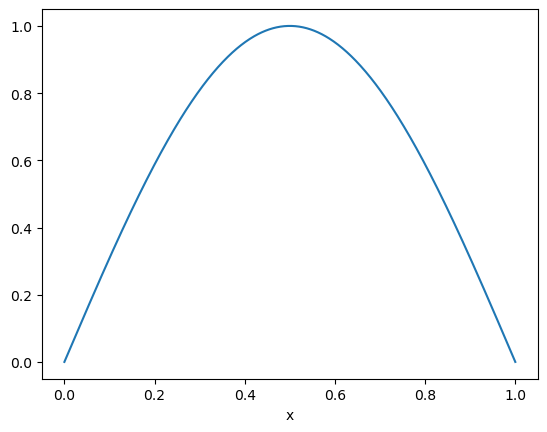

In [7]:
DrawFunction1D(uh)
DrawFunction1D(uef)

### Task `Solve`-5:

Test your implementation of the previous task with a convergence study is in the previous tasks.